In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/merge_15min_filled.csv.tar.gz')
print(zip_path)
df = pd.read_csv(zip_path, compression='tar')

/Users/watcharinsarachai/.keras/datasets/merge_15min_filled.csv.tar.gz


In [4]:
df.head(3)

,datetime,ambient_temperature,current_power,current_value_of_consumption,external_energy_supply,grid_feed_in,internal_power_supply,self_consumption,temperature_measurement,total_irradiation,...,sp,sshf,ssr,ssrd,str,strd,t2m,tp,u10,v10
0,2021-11-06 11:15:00,30.288889,46519.355556,37280.422222,0.0,9238.933333,37280.422222,37280.422222,58.022222,798.444444,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
1,2021-11-06 11:30:00,30.076923,47600.714286,39472.626374,0.0,9397.756098,39132.406593,39132.406593,58.263736,812.571429,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
2,2021-11-06 11:45:00,30.629213,47056.988764,32669.393258,0.0,14387.595506,32669.393258,32669.393258,57.235955,807.224719,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603


In [5]:
for col in df.columns:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        print(f"{col}: {missing_count} missing values")

In [6]:
df.pop('current_value_of_consumption')
df.pop('external_energy_supply')
df.pop('grid_feed_in')
df.pop('internal_power_supply')
df.pop('self_consumption')
df.head(2)

,datetime,ambient_temperature,current_power,temperature_measurement,total_irradiation,utci_mean,cc,q,r,t,...,sp,sshf,ssr,ssrd,str,strd,t2m,tp,u10,v10
0,2021-11-06 11:15:00,30.288889,46519.355556,58.022222,798.444444,302.213731,0.0,0.011205,63.667006,293.487773,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
1,2021-11-06 11:30:00,30.076923,47600.714286,58.263736,812.571429,302.213731,0.0,0.011205,63.667006,293.487773,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603


In [7]:
# Check what years exist in your dataset
date_col = 'datetime'  # Replace with your actual column name

df = df.sort_values(date_col).reset_index(drop=True)

# Ensure timestamp column is datetime type
if df[date_col].dtype != 'datetime64[ns]':
    df[date_col] = pd.to_datetime(df[date_col])

# Sort by time if it exists
df.index = df[date_col]
df.pop(date_col)
df = df.sort_index()
print(df.shape)

df.head(5)

(138238, 23)


,ambient_temperature,current_power,temperature_measurement,total_irradiation,utci_mean,cc,q,r,t,u,...,sp,sshf,ssr,ssrd,str,strd,t2m,tp,u10,v10
datetime,,,,,,,,,,,,,,,,,,,,,
2021-11-06 11:15:00,30.288889,46519.355556,58.022222,798.444444,302.213731,0.0,0.011205,63.667006,293.487773,0.555862,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
2021-11-06 11:30:00,30.076923,47600.714286,58.263736,812.571429,302.213731,0.0,0.011205,63.667006,293.487773,0.555862,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
2021-11-06 11:45:00,30.629213,47056.988764,57.235955,807.224719,302.213731,0.0,0.011205,63.667006,293.487773,0.555862,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
2021-11-06 12:00:00,31.021978,48415.835165,56.846154,817.527473,299.223424,0.0,0.011366,65.189689,293.320821,0.497185,...,96169.262638,-1.129156e+06,1.577950e+07,1.890126e+07,-4.231913e+06,1.548664e+07,297.380576,4.261732e-07,0.378476,0.374936
2021-11-06 12:15:00,31.831461,49345.404494,55.842697,816.651685,299.223424,0.0,0.011366,65.189689,293.320821,0.497185,...,96169.262638,-1.129156e+06,1.577950e+07,1.890126e+07,-4.231913e+06,1.548664e+07,297.380576,4.261732e-07,0.378476,0.374936


In [8]:
mapping = {
  'ambient_temperature': 'ambient_temperature',
  'current_power': 'current_power',
  'temperature_measurement': 'module_temperature',
  'total_irradiation': 'total_irradiation',
  'utci_mean': 'utci_mean',
  'cc': 'cloud_cover',
  'q': 'specific_humidity',
  'r': 'relative_humidity',
  't': 'air_temperature',
  'u': 'wind_u_component',
  'v': 'wind_v_component',
  'fal': 'forecast_accumulated_liquid',
  'slhf': 'surface_latent_heat_flux',
  'sp': 'surface_pressure',
  'sshf': 'sensible_heat_flux',
  'ssr': 'surface_solar_radiation',
  'ssrd': 'surface_solar_radiation_direct',
  'str': 'surface_thermal_radiation',
  'strd': 'surface_thermal_radiation_direct',
  't2m': 'two_m_temperature',
  'tp': 'total_precipitation',
  'u10': 'u10_wind',
  'v10': 'v10_wind',
}
df = df.rename(columns=mapping)

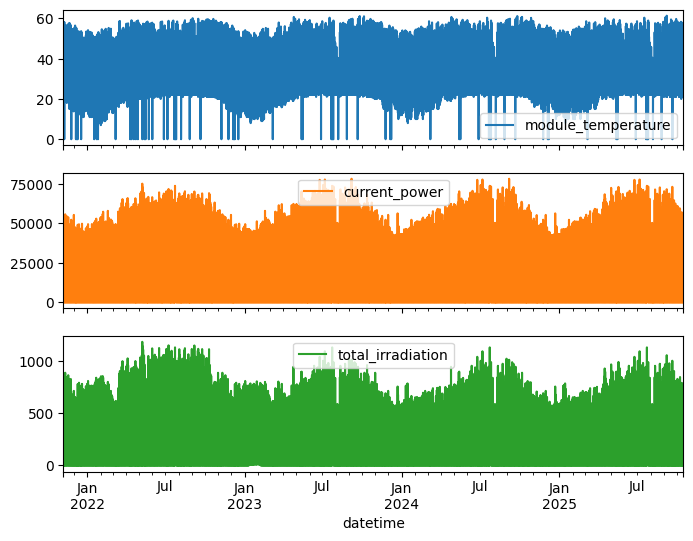

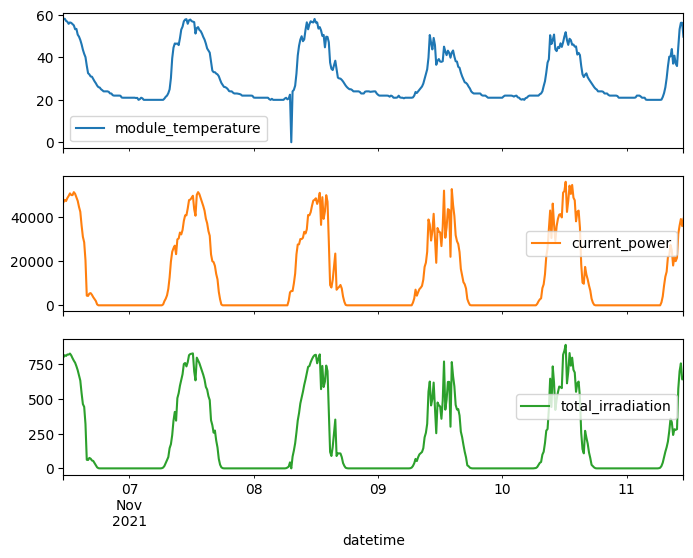

In [9]:
plot_cols = ['module_temperature', 'current_power', 'total_irradiation']
plot_features = df[plot_cols]
plot_features.index = df.index
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = df.index[:480]
_ = plot_features.plot(subplots=True)

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ambient_temperature,138238.0,2.583504e+01,5.150631e+00,0.000000e+00,2.310989e+01,2.600000e+01,2.913483e+01,4.001099e+01
current_power,138238.0,1.305281e+04,1.815287e+04,0.000000e+00,0.000000e+00,0.000000e+00,2.526932e+04,7.825989e+04
module_temperature,138238.0,2.972648e+01,1.188849e+01,0.000000e+00,2.200000e+01,2.506593e+01,3.835227e+01,6.137363e+01
total_irradiation,138238.0,1.558014e+02,2.449202e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.658961e+02,1.183055e+03
utci_mean,138238.0,2.841147e+02,6.759370e+01,0.000000e+00,2.950198e+02,2.991934e+02,3.050845e+02,3.170079e+02
cloud_cover,138238.0,4.359805e-02,1.272938e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.337181e-02,1.000000e+00
specific_humidity,138238.0,1.155237e-02,3.095912e-03,0.000000e+00,9.139406e-03,1.240514e-02,1.411958e-02,1.746720e-02
relative_humidity,138238.0,7.105046e+01,1.935290e+01,0.000000e+00,5.918899e+01,7.650769e+01,8.576274e+01,1.018295e+02
air_temperature,138238.0,2.912035e+02,1.826893e+01,0.000000e+00,2.909458e+02,2.922866e+02,2.937318e+02,3.033400e+02
wind_u_component,138238.0,1.579913e+00,3.781639e+00,-1.205189e+01,-1.115728e+00,1.584174e+00,4.060733e+00,1.637189e+01


In [11]:
print(df.index.year.unique())
print(df.index.year.value_counts())

Index([2021, 2022, 2023, 2024, 2025], dtype='int32', name='datetime')
datetime
2024    35136
2022    35040
2023    35040
2025    27691
2021     5331
Name: count, dtype: int64


In [12]:
df_proced = df.copy()
df_proced = df_proced.ffill() # forward fill to impute missing values
df_proced.head(3)

,ambient_temperature,current_power,module_temperature,total_irradiation,utci_mean,cloud_cover,specific_humidity,relative_humidity,air_temperature,wind_u_component,...,surface_pressure,sensible_heat_flux,surface_solar_radiation,surface_solar_radiation_direct,surface_thermal_radiation,surface_thermal_radiation_direct,two_m_temperature,total_precipitation,u10_wind,v10_wind
datetime,,,,,,,,,,,,,,,,,,,,,
2021-11-06 11:15:00,30.288889,46519.355556,58.022222,798.444444,302.213731,0.0,0.011205,63.667006,293.487773,0.555862,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
2021-11-06 11:30:00,30.076923,47600.714286,58.263736,812.571429,302.213731,0.0,0.011205,63.667006,293.487773,0.555862,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
2021-11-06 11:45:00,30.629213,47056.988764,57.235955,807.224719,302.213731,0.0,0.011205,63.667006,293.487773,0.555862,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603


In [13]:
mean = df_proced.mean()
std = df_proced.std()

df_proced = (df_proced - mean) / std

[Text(0, 0, 'ambient_temperature'),
 Text(1, 0, 'current_power'),
 Text(2, 0, 'module_temperature'),
 Text(3, 0, 'total_irradiation'),
 Text(4, 0, 'utci_mean'),
 Text(5, 0, 'cloud_cover'),
 Text(6, 0, 'specific_humidity'),
 Text(7, 0, 'relative_humidity'),
 Text(8, 0, 'air_temperature'),
 Text(9, 0, 'wind_u_component'),
 Text(10, 0, 'wind_v_component'),
 Text(11, 0, 'forecast_accumulated_liquid'),
 Text(12, 0, 'surface_latent_heat_flux'),
 Text(13, 0, 'surface_pressure'),
 Text(14, 0, 'sensible_heat_flux'),
 Text(15, 0, 'surface_solar_radiation'),
 Text(16, 0, 'surface_solar_radiation_direct'),
 Text(17, 0, 'surface_thermal_radiation'),
 Text(18, 0, 'surface_thermal_radiation_direct'),
 Text(19, 0, 'two_m_temperature'),
 Text(20, 0, 'total_precipitation'),
 Text(21, 0, 'u10_wind'),
 Text(22, 0, 'v10_wind')]

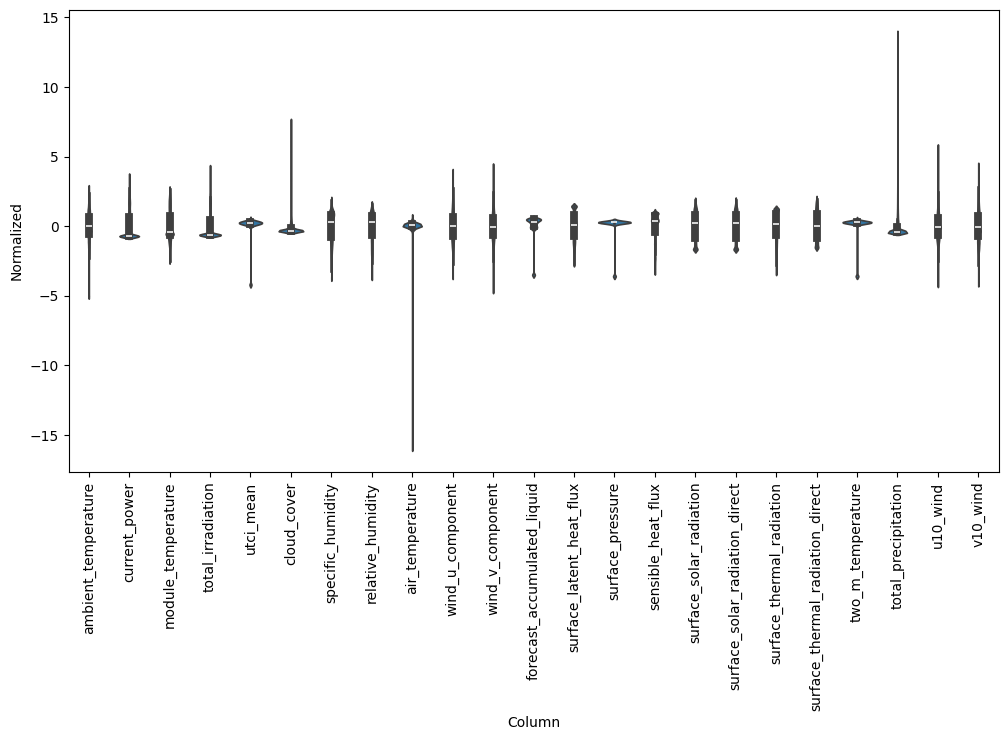

In [14]:
#df_std = (df - train_mean) / train_std
df_std = df_proced.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
ax.set_xticks(range(len(df_proced.keys())))
ax.set_xticklabels(df_proced.keys(), rotation=90)

Text(0, 0.5, 'Forecast Accumulated Liquid')

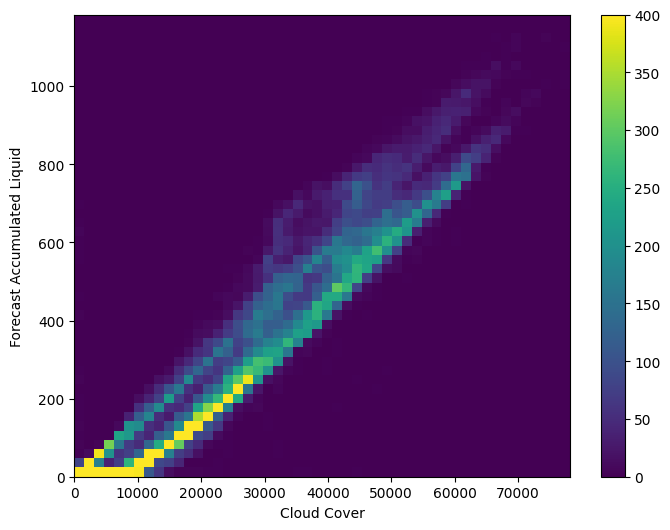

In [15]:
plt.hist2d(df['current_power'], df['total_irradiation'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Cloud Cover')
plt.ylabel('Forecast Accumulated Liquid')

In [16]:
print(df_proced.index.min())
print(df_proced.index.max())

2021-11-06 11:15:00
2025-10-16 10:30:00


In [17]:
column_indices = {name: i for i, name in enumerate(df_proced.columns)}

n = len(df_proced)
test_df = df_proced[0:int(n*0.2)]
train_df = df_proced[int(n*0.2):int(n*0.8)]
val_df = df_proced[int(n*0.8):]

num_features = df_proced.shape[1]

In [18]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}

    excluded = label_columns
    numerical_features = self.train_df.select_dtypes(include=[np.number]).columns.tolist()
      
    self.feature_columns = [col for col in numerical_features if col not in excluded]
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='current_power', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      # plot input value
      plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      # plot label
      plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [15min]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
    
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result
  
  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [19]:
field_name = 'current_power'
df_proced[field_name]

datetime
2021-11-06 11:15:00    1.843595
2021-11-06 11:30:00    1.903165
2021-11-06 11:45:00    1.873212
2021-11-06 12:00:00    1.948068
2021-11-06 12:15:00    1.999276
                         ...   
2025-10-16 09:30:00    0.805390
2025-10-16 09:45:00    1.352052
2025-10-16 10:00:00    1.135175
2025-10-16 10:15:00    1.518317
2025-10-16 10:30:00    1.767763
Name: current_power, Length: 138238, dtype: float64

In [20]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['current_power'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['current_power']

In [21]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:wide_window.total_window_size]),
                           np.array(train_df[100:100+wide_window.total_window_size]),
                           np.array(train_df[200:200+wide_window.total_window_size])])

example_inputs, example_labels = wide_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 25, 23)
Inputs shape: (3, 24, 23)
Labels shape: (3, 24, 1)


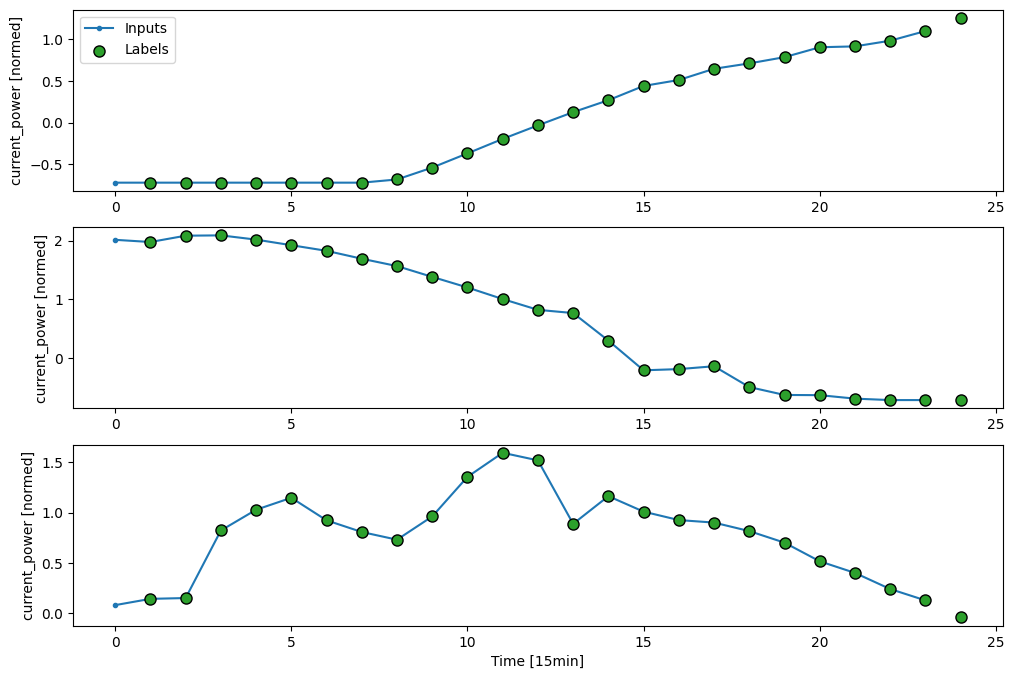

In [22]:
wide_window.plot()

In [23]:
# Each element is an (inputs, label) pair.
wide_window.train.element_spec

(TensorSpec(shape=(None, 24, 23), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))

In [24]:
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 23)
Labels shape (batch, time, features): (32, 24, 1)


2025-12-05 00:45:52.057792: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['current_power'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['current_power']

In [35]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 23)
Labels shape (batch, time, features): (32, 1, 1)


2025-12-05 00:54:22.818549: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [37]:
baseline = Baseline(label_index=column_indices['current_power'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - loss: 0.0652 - mean_absolute_error: 0.1158


In [38]:
print(f'performance:     {performance}')
print(f'val_performance: {val_performance}')

performance:     {'Baseline': {'loss': 0.05705960467457771, 'mean_absolute_error': 0.10531041026115417}}
val_performance: {'Baseline': {'loss': 0.0651971623301506, 'mean_absolute_error': 0.11578010022640228}}


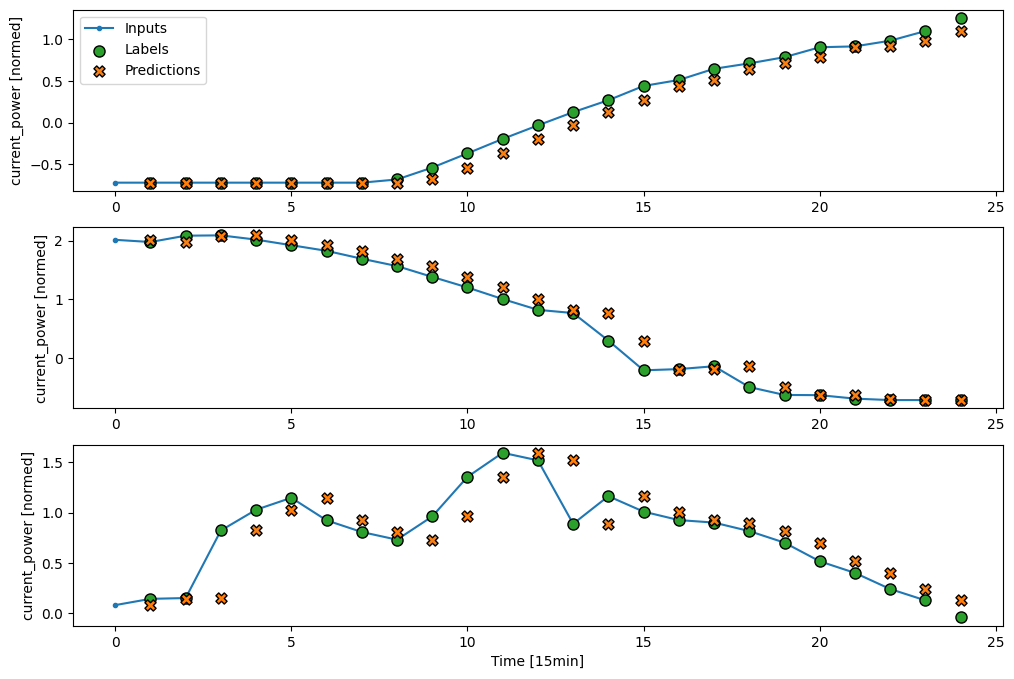

In [40]:
wide_window.plot(baseline)

In [41]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [42]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 23)
Output shape: (32, 24, 1)


In [43]:
MAX_EPOCHS = 50
LEARNING_RATE = 0.001

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Nadam(learning_rate=LEARNING_RATE),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [44]:
history = compile_and_fit(linear, wide_window)

val_performance['Linear'] = linear.evaluate(wide_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0, return_dict=True)

Epoch 1/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2916 - mean_absolute_error: 0.3070 - val_loss: 3.0807 - val_mean_absolute_error: 0.6889
Epoch 2/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0564 - mean_absolute_error: 0.1210 - val_loss: 1.6106 - val_mean_absolute_error: 0.4361
Epoch 3/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0533 - mean_absolute_error: 0.1127 - val_loss: 0.4699 - val_mean_absolute_error: 0.2590
Epoch 4/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0529 - mean_absolute_error: 0.1109 - val_loss: 0.1509 - val_mean_absolute_error: 0.1638
Epoch 5/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0528 - mean_absolute_error: 0.1105 - val_loss: 0.0867 - val_mean_absolute_error: 0.1518
Epoch 6/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0528 - mean_absolute_error: 0.1103 - val_loss: 0.0760 - val_mean_absolute_error: 0.1604
Epoch 7/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0528 - mean_absolute_err

In [45]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 23)
Output shape: (32, 24, 1)


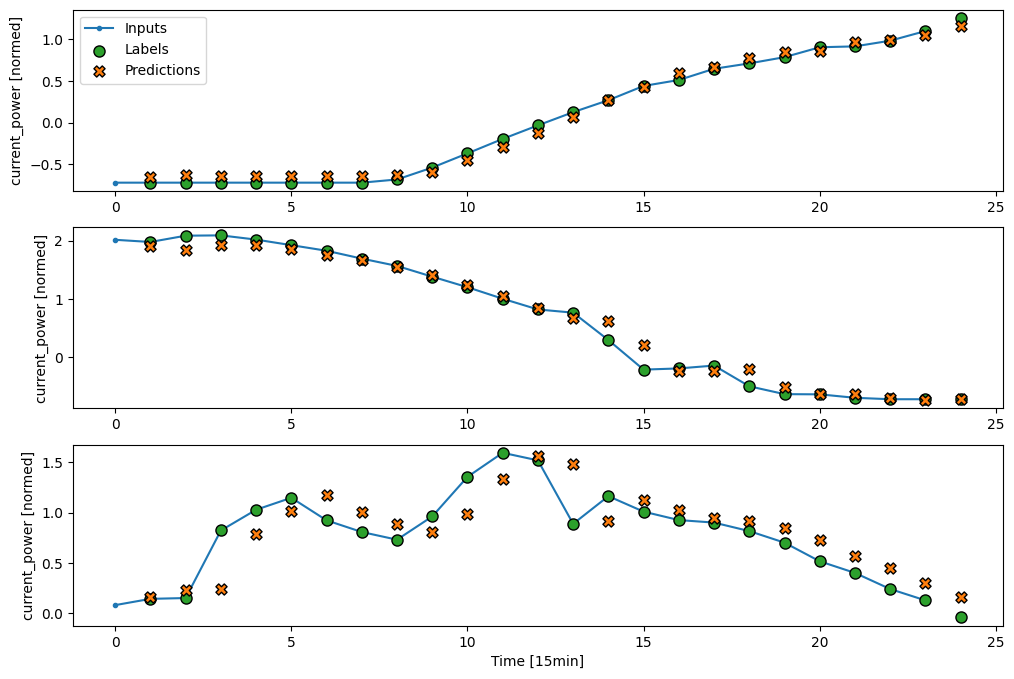

In [46]:
wide_window.plot(linear)

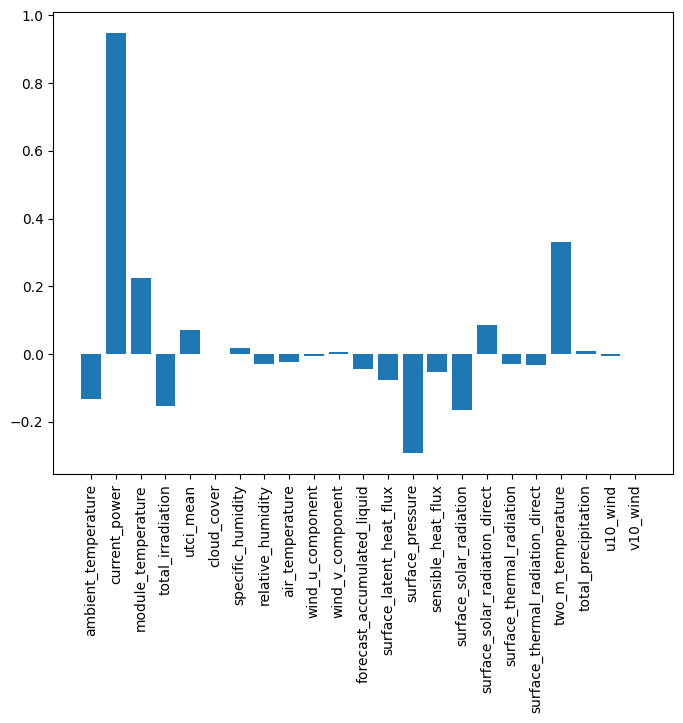

In [47]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [48]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, wide_window)

val_performance['Dense'] = dense.evaluate(wide_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0, return_dict=True)

Epoch 1/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.0477 - mean_absolute_error: 0.1049 - val_loss: 0.0935 - val_mean_absolute_error: 0.1807
Epoch 2/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 84s 32ms/step - loss: 0.0412 - mean_absolute_error: 0.0951 - val_loss: 0.1260 - val_mean_absolute_error: 0.1818
Epoch 3/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 86s 33ms/step - loss: 0.0348 - mean_absolute_error: 0.0879 - val_loss: 0.1669 - val_mean_absolute_error: 0.2043
864/864 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1669 - mean_absolute_error: 0.2043


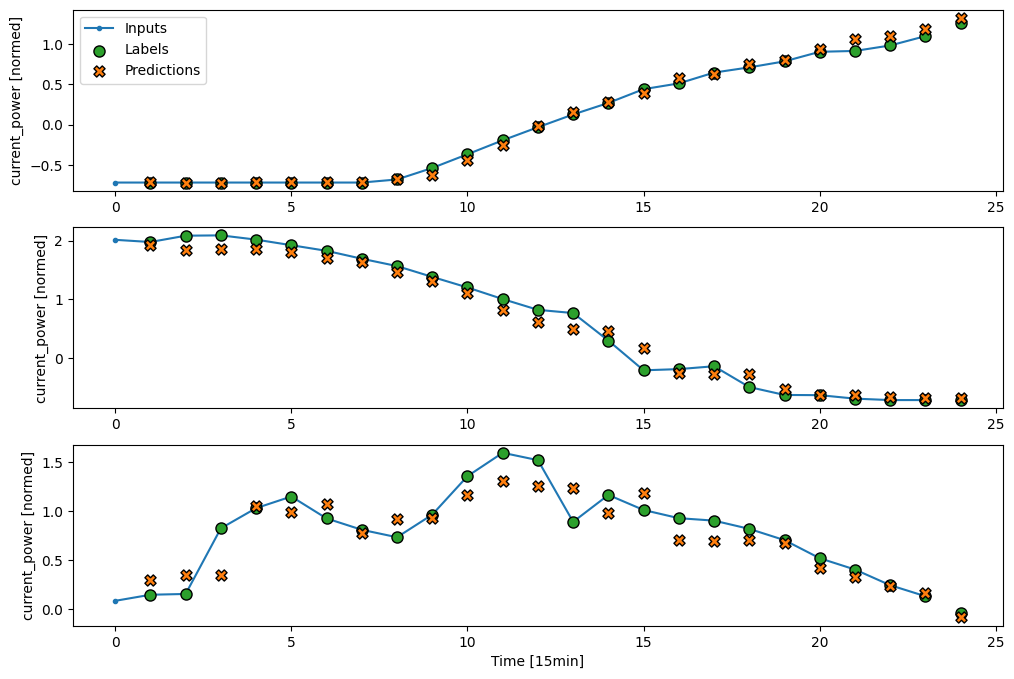

In [49]:
wide_window.plot(dense)

In [50]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, wide_window)

val_performance['Dense'] = dense.evaluate(wide_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0, return_dict=True)

Epoch 1/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0506 - mean_absolute_error: 0.1090 - val_loss: 0.1687 - val_mean_absolute_error: 0.2197
Epoch 2/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0439 - mean_absolute_error: 0.0979 - val_loss: 0.1225 - val_mean_absolute_error: 0.1844
Epoch 3/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0416 - mean_absolute_error: 0.0957 - val_loss: 0.1291 - val_mean_absolute_error: 0.1868
Epoch 4/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0394 - mean_absolute_error: 0.0941 - val_loss: 0.1328 - val_mean_absolute_error: 0.1936
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1328 - mean_absolute_error: 0.1936


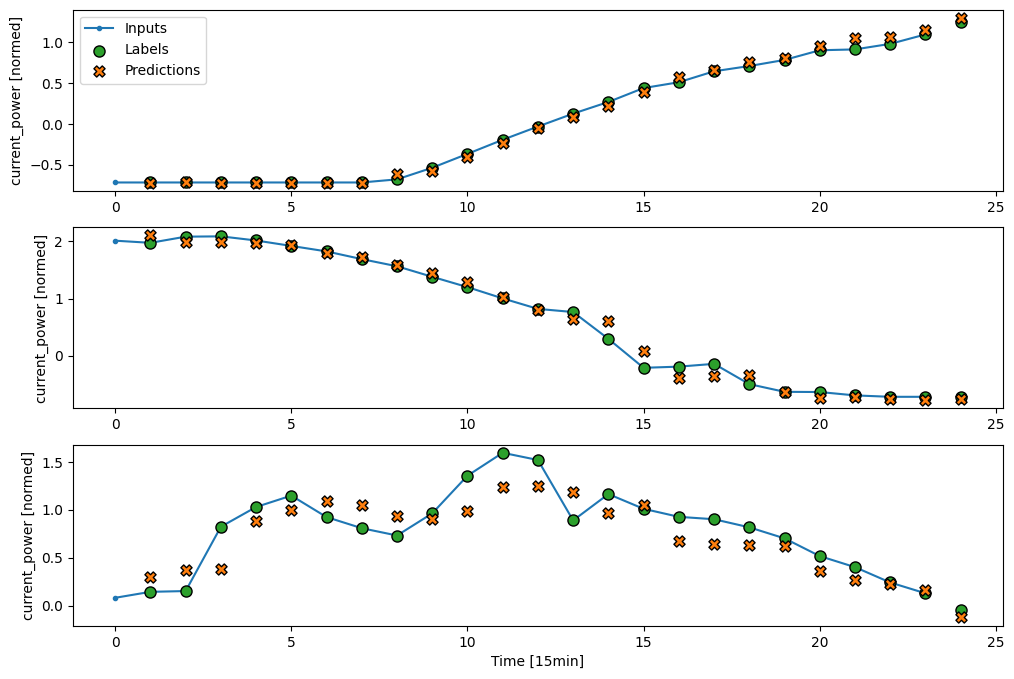

In [51]:
wide_window.plot(dense)

In [40]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

history = compile_and_fit(multi_step_dense, wide_window)

val_performance['MultiStepDense'] = multi_step_dense.evaluate(wide_window.val, return_dict=True)
performance['MultiStepDense'] = multi_step_dense.evaluate(wide_window.test, verbose=0, return_dict=True)

Epoch 1/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.3202 - mean_absolute_error: 0.3723 - val_loss: 0.4538 - val_mean_absolute_error: 0.4585
Epoch 2/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.3120 - mean_absolute_error: 0.3586 - val_loss: 0.4268 - val_mean_absolute_error: 0.4342
Epoch 3/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.3118 - mean_absolute_error: 0.3576 - val_loss: 1.0266 - val_mean_absolute_error: 0.6844
Epoch 4/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.3116 - mean_absolute_error: 0.3563 - val_loss: 0.4637 - val_mean_absolute_error: 0.4582
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - loss: 0.4637 - mean_absolute_error: 0.4582


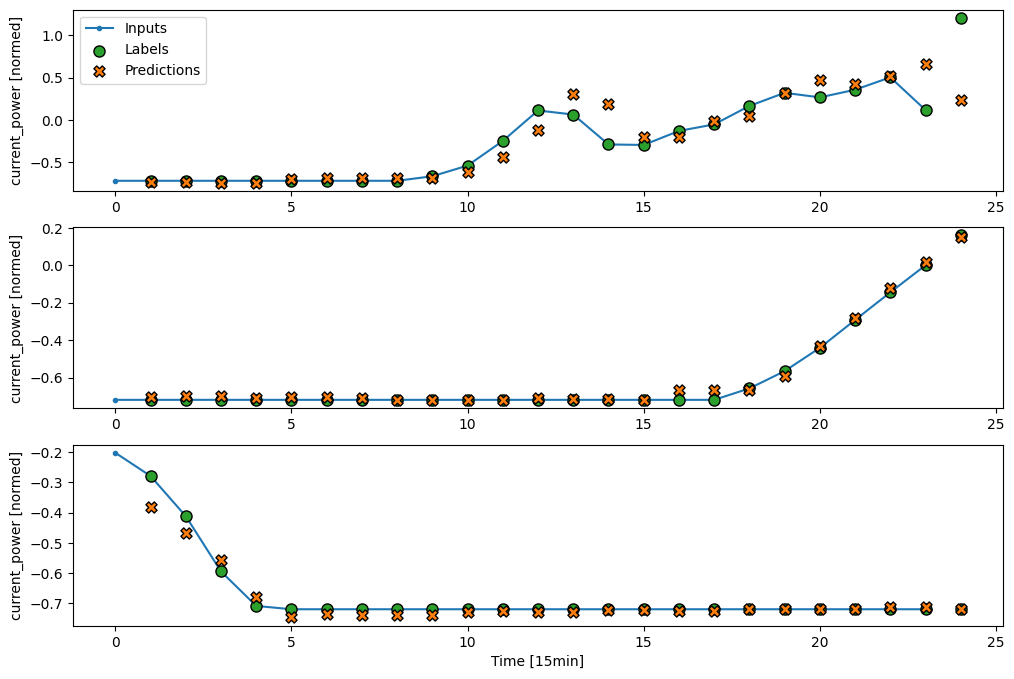

In [41]:
wide_window.plot(dense)

In [42]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

history = compile_and_fit(multi_step_dense, wide_window)

val_performance['MultiStepDense'] = multi_step_dense.evaluate(wide_window.val, return_dict=True)
performance['MultiStepDense'] = multi_step_dense.evaluate(wide_window.test, verbose=0, return_dict=True)

Epoch 1/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.3235 - mean_absolute_error: 0.3761 - val_loss: 0.3362 - val_mean_absolute_error: 0.3807
Epoch 2/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.3122 - mean_absolute_error: 0.3598 - val_loss: 0.3404 - val_mean_absolute_error: 0.3799
Epoch 3/50
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.3118 - mean_absolute_error: 0.3578 - val_loss: 0.3490 - val_mean_absolute_error: 0.3790
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3490 - mean_absolute_error: 0.3790


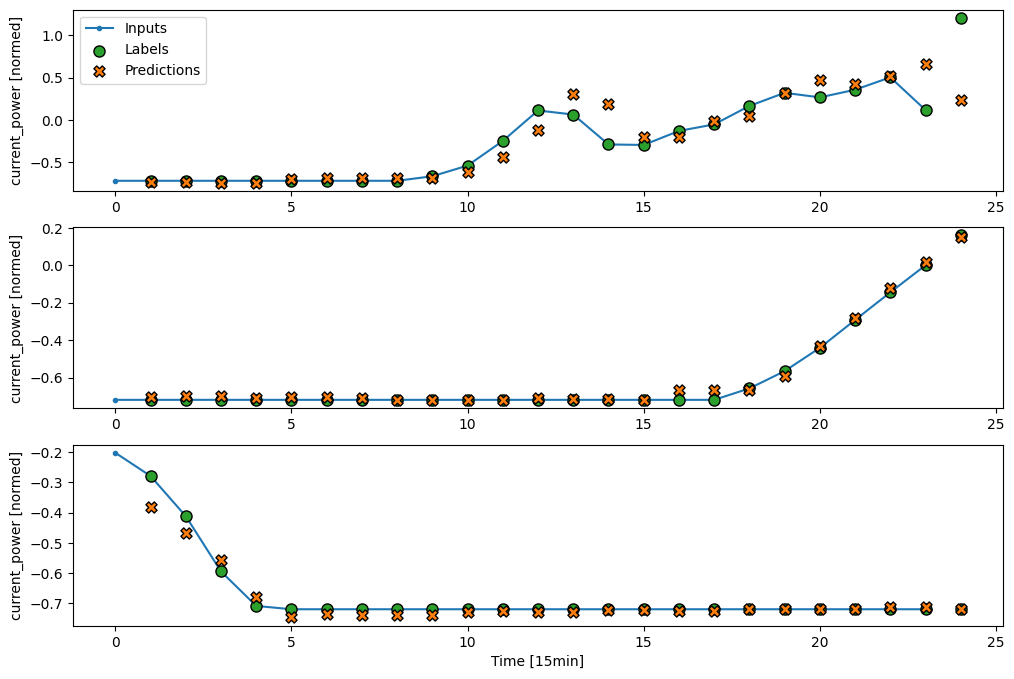

In [43]:
wide_window.plot(dense)

437/437 [==============================] - 1s 1ms/step - loss: 0.2140 - mean_absolute_error: 0.2795


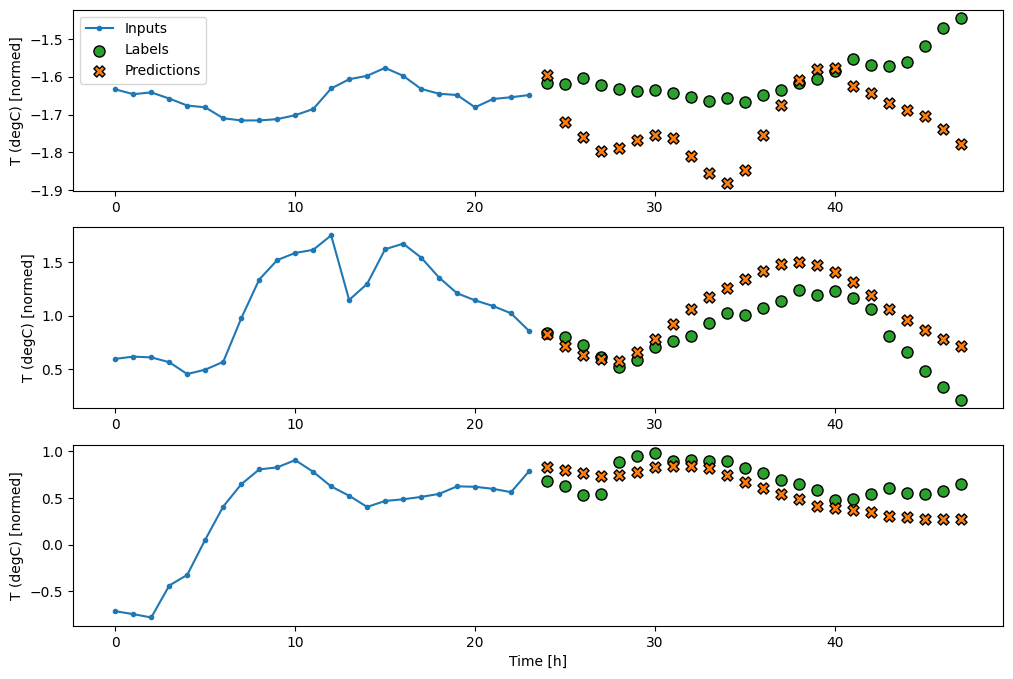

In [82]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

Epoch 1/20
1532/1532 [==============================] - 18s 11ms/step - loss: 0.2918 - mean_absolute_error: 0.3617 - val_loss: 0.2311 - val_mean_absolute_error: 0.3079
Epoch 2/20
 655/1532 [===========>..................] - ETA: 8s - loss: 0.2207 - mean_absolute_error: 0.2983